In [1]:
import chess
import chess.pgn
import ipywidgets as widgets
import chess.svg
from IPython.display import display, clear_output
import time
from versions.my_engine_v1 import get_best_move as v1
from versions.my_engine_v2 import get_best_move as v2
from stockfish import Stockfish

# board = chess.Board(fen="r1bqk1r1/ppp2pp1/2n1p2p/3p2N1/2PPn2P/P3PP2/1P1B2P1/R2QKB1R b KQq - 0 2")
board = chess.Board()
AI_DEPTH = 3


In [2]:


def play_once_stockfish(new_version=False,claim_draw=True,AI_DEPTH=AI_DEPTH,board=board,pre_version=v1):
    
    sf = Stockfish(path="./stockfish/stockfish-windows-x86-64-avx2.exe",depth=AI_DEPTH)
    game = chess.pgn.Game()
    game.headers["Event"] = "AI vs AI"
    game.headers["Site"] = "Local"
    node = game 
    
    start_time = time.perf_counter()

    while not board.is_game_over(claim_draw=claim_draw):
        if board.turn == chess.WHITE:
            # move = pre_version(board, AI_DEPTH)
            sf.set_fen_position(board.fen())
            move = chess.Move.from_uci(sf.get_best_move())
            # move_tmp=input("move: ")
            # move=chess.Move.from_uci(move_tmp)
        elif new_version:
            move = new_version(board, AI_DEPTH)
        else:
            sf.set_fen_position(board.fen())
            move = chess.Move.from_uci(sf.get_best_move())

        board.push(move)
        node = node.add_variation(move)
        # Visualization
        clear_output(wait=True)
        display(chess.svg.board(board, size=400))

    end_time = time.perf_counter()

    result = board.result(claim_draw=True)
    game.headers["Result"] = result
    print(f"Outcome: {board.outcome(claim_draw=True)}")
    print(f"\ntime taken {end_time-start_time} PGN Output: ",game)
    board.reset_board()


In [3]:
def play_stockfish(count,new_version=False, show=True ,claim_draw=True,AI_DEPTH=AI_DEPTH, board=board, pre_version=v1):
    white_won = 0
    black_won = 0
    draw = 0
    sf = Stockfish(path="./stockfish/stockfish-windows-x86-64-avx2.exe", depth=AI_DEPTH)
    for i in range(count):
        print(f"Playing game:- {i+1}/{count}", end=" ")
        while not board.is_game_over(claim_draw=claim_draw):
            time.sleep(0.01)
            if board.turn == chess.WHITE:
                move = pre_version(board, AI_DEPTH)
            elif new_version:
                move = new_version(board, AI_DEPTH)
            else:
                sf.set_fen_position(board.fen())
                move = chess.Move.from_uci(sf.get_best_move())
                

            board.push(move)
            if show:
                clear_output(wait=True)
                display(chess.svg.board(board, size=400))
                print(f"Playing game:- {i+1}/{count}", end=" ")


        result = board.result(claim_draw=claim_draw)
        if result == "1-0":
            white_won += 1
        elif result == "0-1":
            black_won += 1
        else:
            draw += 1

        print(result)
        board.reset_board()
    
    print(f"\nGames played:- {count} \nWhite won:- {white_won}\nBlack won:- {black_won}\nDraw:- {draw}\n")

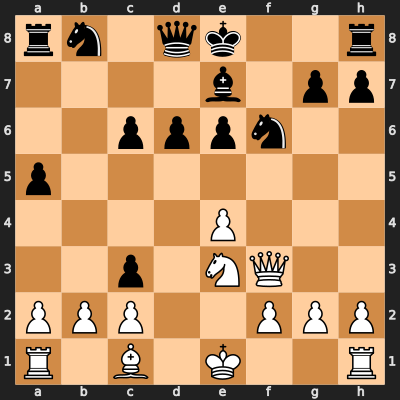

Playing game:- 2/10 

KeyboardInterrupt: 

In [ ]:
play_stockfish(count=3,pre_version=v2,AI_DEPTH=4)
# play_stockfish(count=10,pre_version=v2,AI_DEPTH=3)
# v2(board=board,depth=AI_DEPTH)